In [7]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pacmap import PaCMAP

patient_list = [28, 30, 31, 33, 34, 35]
mn_ratio = 30
fp_ratio = 30
lr = 0.05
animal = "pangolin"

In [8]:
# Initialize empty lists to store data from all patients
all_embeddings = []
all_start_times = []
all_stop_times = []
all_file_indices = []
all_window_indices = []
all_patient_ids = []

# Load and combine data from each patient
for patient_id in patient_list:
    # Load embeddings file
    embedding_path = f'output/{animal}/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'
    with open(embedding_path, 'rb') as f:
        patient_data = pickle.load(f)
    
    # Append data while preserving order
    all_embeddings.append(patient_data['patient_embeddings'])
    all_start_times.extend(patient_data['start_times'])
    all_stop_times.extend(patient_data['stop_times'])
    all_file_indices.extend(patient_data['file_indices'])
    all_window_indices.extend(patient_data['window_indices'])
    all_patient_ids.extend([patient_id] * len(patient_data['start_times']))

# Combine embeddings arrays
combined_embeddings = np.vstack(all_embeddings)

# Create combined dictionary with same structure
combined_data = {
    'patient_id': all_patient_ids,
    'patient_embeddings': combined_embeddings,
    'start_times': all_start_times,
    'stop_times': all_stop_times,
    'file_indices': all_file_indices,
    'window_indices': all_window_indices,
    'original_shape': combined_embeddings.shape,
    'sleep_labels': None
}

with open('source_pickles/combined_data.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

In [9]:
# Set up sleep tagging functions

def find_sleep_stage(start_time, stop_time, sleep_data, patient_id, certainty_threshold):
    """Find sleep stage for a given time window and patient."""
    patient_sleep = sleep_data[
        (sleep_data['PatID'] == patient_id) & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    if len(patient_sleep) == 0:
        return 'unknown'
    
    # Check for overlapping sleep stages
    overlapping_stages = patient_sleep[
        (patient_sleep['OnsetDatetime'] <= stop_time) & 
        (patient_sleep['OffsetDatetime'] >= start_time)
    ]
    
    if len(overlapping_stages) > 0:
        sleep_stage = overlapping_stages.iloc[0]['SleepCat']
        # Group N2 and N3 into N
        return 'N' if sleep_stage in ['N2', 'N3'] else sleep_stage
    return 'unknown'


def tag_points(patient_list, sleep_data, certainty_threshold):
    """Tag points with sleep stage metadata and update combined_data.pkl."""
    print("\nLoading combined data...")
    with open('source_pickles/combined_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Debug: check the format of stored patient IDs
    print("\nSample of patient IDs in data:", data['patient_id'][:5])
    print("Type of first patient ID:", type(data['patient_id'][0]))
    
    print("\nProcessing patient data...")
    sleep_stages = []
    
    # Get unique patient IDs
    unique_patients = sorted(patient_list)
    print(f"Found {len(unique_patients)} patients in data")
    
   # Process each patient's points
    for pat_id in unique_patients:
        print(f"\nTagging sleep stages for Epat{pat_id}")
        
        # Get indices for this patient's points
        pat_mask = np.array([pat_id == pid for pid in data['patient_id']])
        print(f"Number of points for patient {pat_id}: {sum(pat_mask)}")
        
        # Get this patient's sleep metadata
        pat_sleep = sleep_data[
            (sleep_data['PatID'] == f"Epat{pat_id}") & 
            (sleep_data['AvgCertainty'] >= certainty_threshold)
        ]
        
        if len(pat_sleep) == 0:
            print(f"No sleep events found for Epat{pat_id}")
            pat_stages = ['unknown'] * sum(pat_mask)
            print(f"Added {len(pat_stages)} 'unknown' labels")
        else:
            print(f"Found {len(pat_sleep)} sleep events")
            pat_stages = []
            
            # Get file start times for this patient
            file_starts = np.array(data['start_times'])[pat_mask]
            file_stops = np.array(data['stop_times'])[pat_mask]
            
            # For each file
            for file_start, file_stop in zip(file_starts, file_stops):
                # Calculate window start times using 30-second stride
                window_starts = [file_start + pd.Timedelta(seconds=30*i) for i in range(32)]
                window_stops = [start + pd.Timedelta(seconds=60) for start in window_starts]  # 60-second windows
                
                # Get sleep stage for each window
                for window_start, window_stop in zip(window_starts, window_stops):
                    stage = find_sleep_stage(window_start, window_stop, sleep_data, f"Epat{pat_id}", certainty_threshold)
                    pat_stages.append(stage)
            
            print(f"Added {len(pat_stages)} labels")
        
        sleep_stages.extend(pat_stages)
        print(f"Total labels so far: {len(sleep_stages)}")
    
    # Print summary statistics
    stage_counts = pd.Series(sleep_stages).value_counts()
    print("\nSleep stage distribution:")
    for stage, count in stage_counts.items():
        print(f"{stage}: {count}")
    
    # Update sleep_labels in combined data
    data['sleep_labels'] = sleep_stages
    print("\nSleep labels shape:", np.array(data['sleep_labels']).shape)
    print("Patient embeddings shape:", data['patient_embeddings'].shape)
    
    # Save updated combined data
    print("\nSaving updated combined data...")
    with open('source_pickles/combined_data.pkl', 'wb') as f:
        pickle.dump(data, f)

In [10]:
# Load sleep metadata
sleep_data = pd.read_excel('metadata/cleaned_sleep.xlsx')

# Convert datetime columns
sleep_data['OnsetDatetime'] = pd.to_datetime(sleep_data['OnsetDatetime'])
sleep_data['OffsetDatetime'] = pd.to_datetime(sleep_data['OffsetDatetime'])

In [11]:
tag_points(patient_list, sleep_data, 0.6)

with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

embeddings = combined_data['patient_embeddings']
print("Embeddings shape:", embeddings.shape)
flat_embeddings = embeddings.reshape(-1, embeddings.shape[-1])
print("Reshaped embeddings shape:", flat_embeddings.shape)

sleep_labels = combined_data['sleep_labels']
print('Sleep labels shape:', len(sleep_labels))
print(sleep_labels)


Loading combined data...

Sample of patient IDs in data: [28, 28, 28, 28, 28]
Type of first patient ID: <class 'int'>

Processing patient data...
Found 6 patients in data

Tagging sleep stages for Epat28
Number of points for patient 28: 896
Found 5 sleep events
Added 28672 labels
Total labels so far: 28672

Tagging sleep stages for Epat30
Number of points for patient 30: 760
Found 12 sleep events
Added 24320 labels
Total labels so far: 52992

Tagging sleep stages for Epat31
Number of points for patient 31: 640
Found 14 sleep events
Added 20480 labels
Total labels so far: 73472

Tagging sleep stages for Epat33
Number of points for patient 33: 536
Found 18 sleep events
Added 17152 labels
Total labels so far: 90624

Tagging sleep stages for Epat34
Number of points for patient 34: 680
Found 16 sleep events
Added 21760 labels
Total labels so far: 112384

Tagging sleep stages for Epat35
Number of points for patient 35: 280
No sleep events found for Epat35
Added 280 'unknown' labels
Total la

In [42]:
pacmap_params = {
    'n_components': 2,
    'MN_ratio': 15,
    'FP_ratio': 5,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=150, n_FP=50, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((1213440, 2), (18201600, 2), (6067200, 2))
Initial Loss: 5353664.0
Iteration:   10, Loss: 4661067.500000
Iteration:   20, Loss: 4420597.000000
Iteration:   30, Loss: 4282709.000000
Iteration:   40, Loss: 3733855.000000
Iteration:   50, Loss: 3448471.750000
Iteration:   60, Loss: 3275893.500000
Iteration:   70, Loss: 3127323.750000
Iteration:   80, Loss: 2608058.750000
Iteration:   90, Loss: 2150570.000000
Iteration:  100, Loss: 1403724.250000
Iteration:  110, Loss: 1217125.125000
Iteration:  120, Loss: 1068784.750000
Iteration:  130, Loss: 983815.000000
Iteration:  140, Loss: 934479.500000
Iteration:  150, Loss: 904056.437500
Iteration:  160, Loss: 883975.375000
Iteration:

Shape of manifold_2d: (121344, 2)
Length of sleep_labels: 112664
Unique sleep labels: ['N' 'R' 'W' 'unknown']
Number of unlabeled points (among those with sleep labels): 110087

Label: W
Number of points with this label: 893

Label: N
Number of points with this label: 1551

Label: R
Number of points with this label: 133


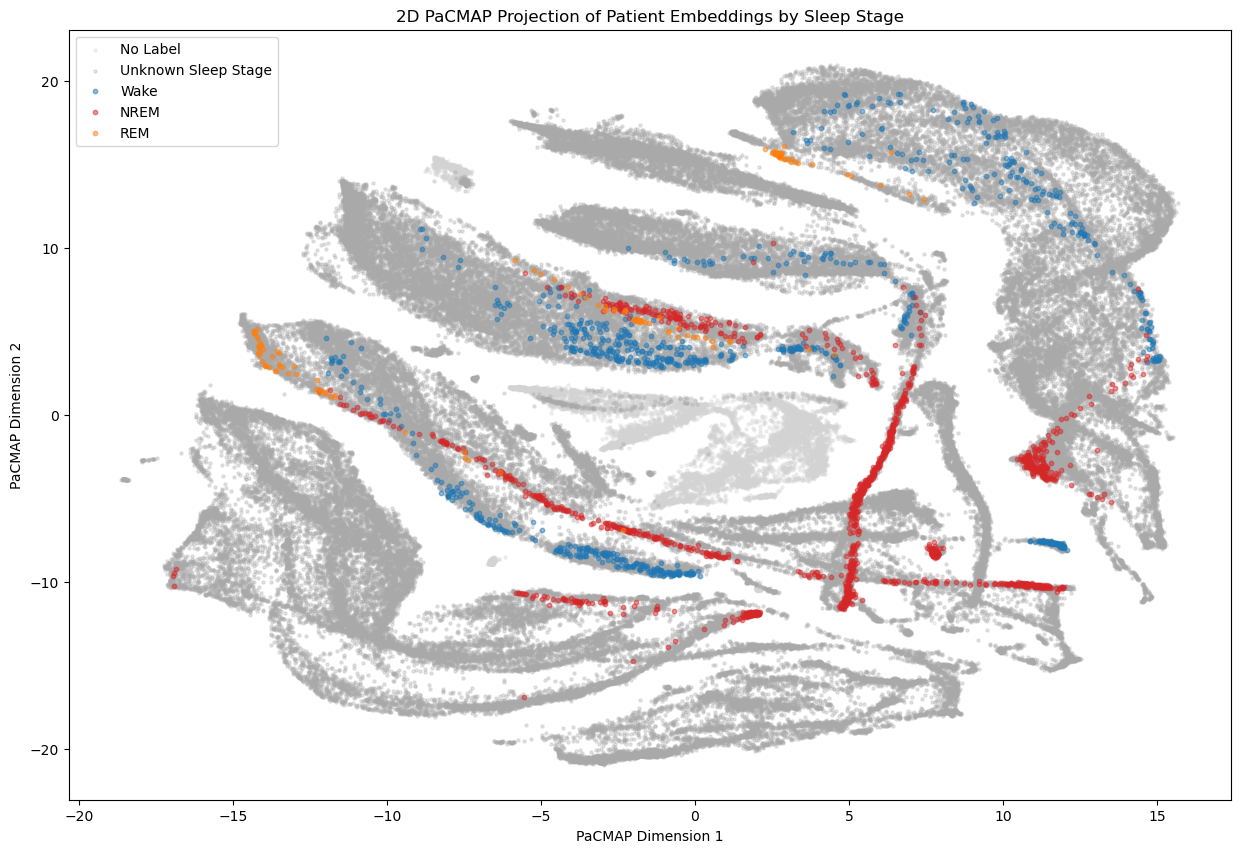

In [43]:
# First make sure matplotlib is imported
import matplotlib.pyplot as plt

# Load the combined data
with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

# Debug prints to check data
print("Shape of manifold_2d:", manifold_2d.shape)
print("Length of sleep_labels:", len(sleep_labels))
print("Unique sleep labels:", np.unique(sleep_labels))

plt.figure(figsize=(15,10))

# Create a mask for points that have labels (first len(sleep_labels) points)
has_label_mask = np.zeros(manifold_2d.shape[0], dtype=bool)
has_label_mask[:len(sleep_labels)] = True

# Plot points without any labels (those beyond len(sleep_labels))
plt.scatter(manifold_2d[~has_label_mask,0], manifold_2d[~has_label_mask,1],
           c='lightgray', alpha=0.3, s=5, label='No Label')

# Among points with labels, plot those with unknown/unlabeled sleep stage
labeled_mask = np.isin(sleep_labels, ['W', 'N', 'R'])
# Create full-length unknown mask
unknown_mask = np.zeros(manifold_2d.shape[0], dtype=bool)
unknown_mask[:len(sleep_labels)] = ~labeled_mask
unknown_mask &= has_label_mask  # Only include points that have labels

print("Number of unlabeled points (among those with sleep labels):", np.sum(~labeled_mask))
plt.scatter(manifold_2d[unknown_mask,0], manifold_2d[unknown_mask,1],
           c='darkgray', alpha=0.3, s=5, label='Unknown Sleep Stage')

sleep_colors = {
    'W': '#1f77b4',  # blue
    'N': '#d62728',  # red
    'R': '#ff7f0e'   # orange
}
sleep_names = {
    'W': 'Wake',
    'N': 'NREM',
    'R': 'REM'
}

# Plot labeled points on top
for label in sleep_colors:
    mask = np.zeros(manifold_2d.shape[0], dtype=bool)
    label_mask = np.array(sleep_labels) == label
    mask[:len(sleep_labels)][label_mask] = True
    
    print(f"\nLabel: {label}")
    print(f"Number of points with this label: {np.sum(mask)}")
    if np.any(mask):
        plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
                   c=sleep_colors[label],
                   label=sleep_names[label],
                   alpha=0.5, s=10)

plt.title('2D PaCMAP Projection of Patient Embeddings by Sleep Stage')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()
plt.show()

3792
3792
Shape of manifold_2d: (121344, 2)
Length of expanded patient IDs: 121344
Shape of original patient embeddings: (3792, 32, 1024)


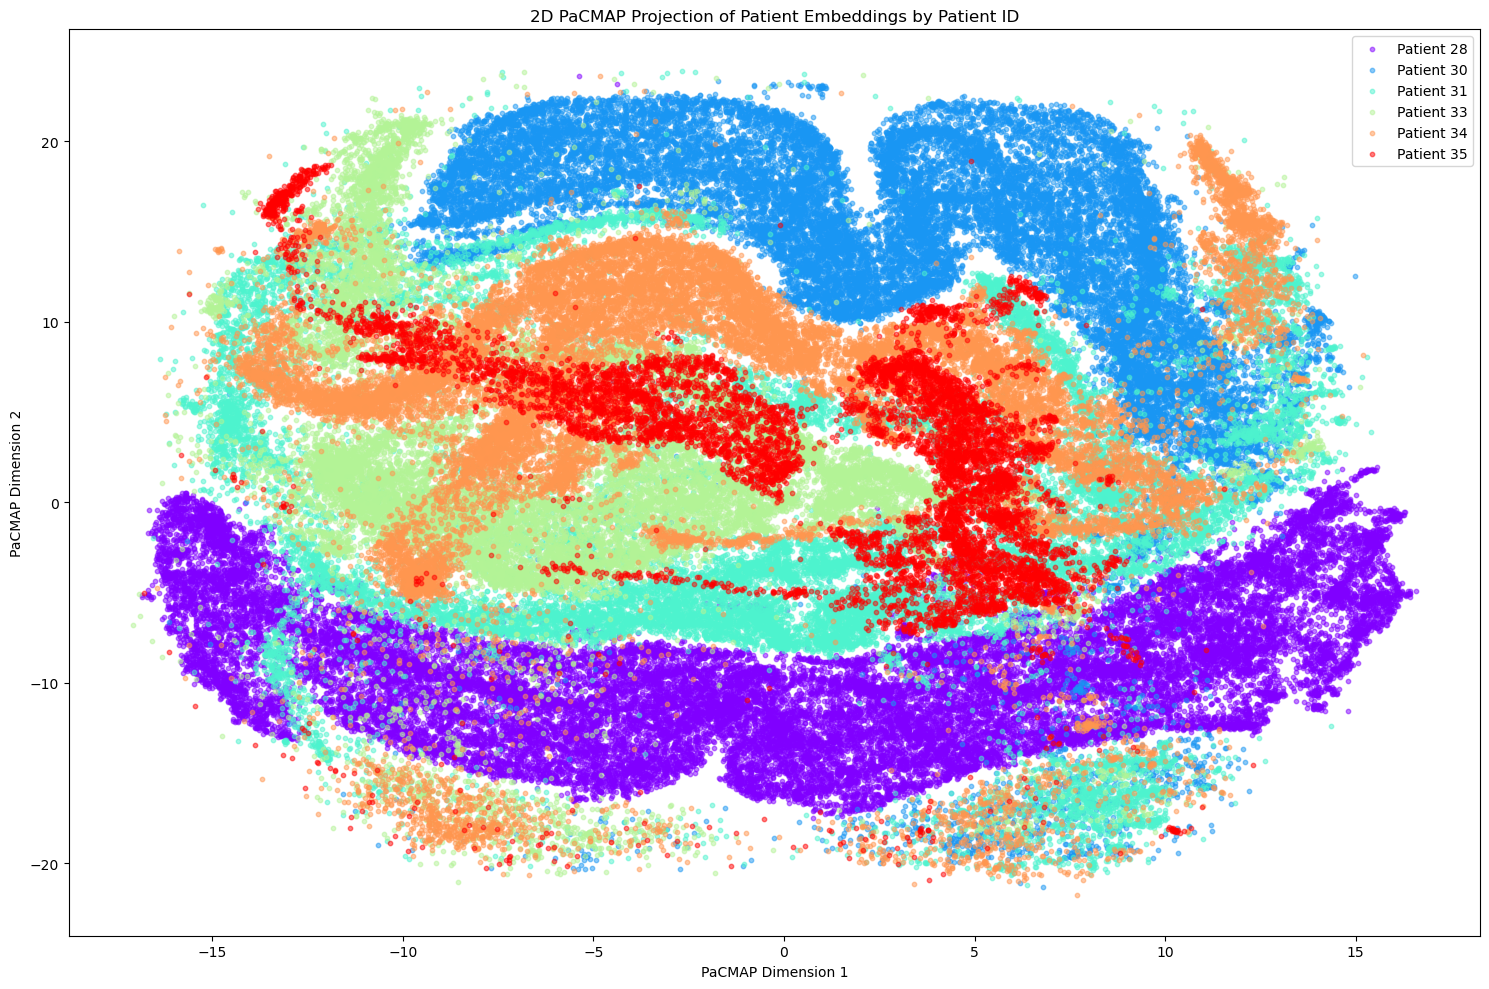

In [15]:
# Load the combined data if not already loaded
with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

print(len(combined_data['patient_embeddings']))
print(len(combined_data['patient_id']))

# Expand patient IDs to match the flattened structure
expanded_patient_ids = np.repeat(combined_data['patient_id'], 32)

plt.figure(figsize=(15,10))

# Add debug prints to check data shapes
print("Shape of manifold_2d:", manifold_2d.shape)
print("Length of expanded patient IDs:", len(expanded_patient_ids))
print("Shape of original patient embeddings:", combined_data['patient_embeddings'].shape)

# Create a color map for unique patient IDs
unique_patients = sorted(set(expanded_patient_ids))
n_patients = len(unique_patients)
colors = plt.cm.rainbow(np.linspace(0, 1, n_patients))

# Plot points for each patient with a different color
for idx, patient_id in enumerate(unique_patients):
    mask = (expanded_patient_ids == patient_id)  # Create boolean mask
    if len(mask) != manifold_2d.shape[0]:
        print(f"Warning: mask length ({len(mask)}) doesn't match manifold_2d length ({manifold_2d.shape[0]})")
        continue
        
    plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
               c=[colors[idx]], 
               label=f'Patient {patient_id}',
               alpha=0.5, s=10)

plt.title('2D PaCMAP Projection of Patient Embeddings by Patient ID')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')

# Adjust legend if there are many patients
if n_patients > 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
else:
    plt.legend()

plt.tight_layout()
plt.savefig(f'figures/{animal}/multipatient/multipatient_space_MN{mn_ratio}_FP{fp_ratio}_Epat28_30_31_33_34_35.svg', format='svg', bbox_inches='tight')

In [29]:
# Initialize empty lists to store pre-ictal data from all patients
all_preictal_embeddings = []
all_preictal_start_times = []
all_preictal_stop_times = []
all_preictal_file_indices = []
all_preictal_window_indices = []
all_preictal_patient_ids = []

# Load seizure metadata
seizure_data = pd.read_excel('metadata/ictal_event_metadata.xlsx')

print(f"Loading seizure data for {len(patient_list)} patients...")

for patient_id in patient_list:
    # Load embeddings file
    embedding_path = f'output/{animal}/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'
    with open(embedding_path, 'rb') as f:
        patient_data = pickle.load(f)
    
    # Get seizure data for this patient
    patient_seizures = seizure_data[seizure_data['Pat ID'] == f'Epat{patient_id}']
    
    if len(patient_seizures) == 0:
        print(f"No seizure events found for patient {patient_id}")
        continue
        
    print(f"Found {len(patient_seizures)} seizure events for patient {patient_id}")
    
    # Clean seizure data
    patient_seizures = patient_seizures[
        ~(
            patient_seizures['Date (MM:DD:YYYY)'].isna() |
            patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr'].isna()
        )
    ]
    
    # Convert date format
    patient_seizures['Date (MM:DD:YYYY)'] = patient_seizures['Date (MM:DD:YYYY)'].apply(
        lambda x: x.split(':')[0] + '/' + x.split(':')[1] + '/' + x.split(':')[2]
    )
    
    # Create datetime objects for seizure onsets
    date_format = '%m/%d/%Y %H:%M:%S'
    patient_seizures['SeizureOnset'] = pd.to_datetime(
        patient_seizures['Date (MM:DD:YYYY)'] + ' ' + 
        patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr'],
        format=date_format
    )
    
    # Convert start_times to datetime if they aren't already
    start_times = pd.to_datetime(patient_data['start_times'])
    
    # Initialize mask for pre-ictal windows
    preictal_mask = np.zeros(len(start_times), dtype=bool)
    
    # For each seizure, mark windows within 1 hour before
    for seizure_time in patient_seizures['SeizureOnset']:
        time_to_seizure = seizure_time - start_times
        preictal_mask |= (time_to_seizure <= pd.Timedelta(hours=3)) & (time_to_seizure > pd.Timedelta(seconds=0))
    
    # Filter data using preictal_mask
    if np.any(preictal_mask):
        all_preictal_embeddings.append(patient_data['patient_embeddings'][preictal_mask])
        all_preictal_start_times.extend(np.array(patient_data['start_times'])[preictal_mask])
        all_preictal_stop_times.extend(np.array(patient_data['stop_times'])[preictal_mask])
        all_preictal_file_indices.extend(np.array(patient_data['file_indices'])[preictal_mask])
        all_preictal_window_indices.extend(np.array(patient_data['window_indices'])[preictal_mask])
        all_preictal_patient_ids.extend([patient_id] * np.sum(preictal_mask))
        
        print(f"Patient {patient_id}: Found {np.sum(preictal_mask)} pre-ictal windows")

# Combine pre-ictal embeddings arrays
combined_preictal_embeddings = np.vstack(all_preictal_embeddings)

# Create combined dictionary with pre-ictal data
combined_preictal_data = {
    'patient_id': all_preictal_patient_ids,
    'patient_embeddings': combined_preictal_embeddings,
    'start_times': all_preictal_start_times,
    'stop_times': all_preictal_stop_times,
    'file_indices': all_preictal_file_indices,
    'window_indices': all_preictal_window_indices,
    'original_shape': combined_preictal_embeddings.shape,
    'sleep_labels': None
}

# Save the pre-ictal combined data
with open('source_pickles/combined_preictal_data.pkl', 'wb') as f:
    pickle.dump(combined_preictal_data, f)

# Reshape embeddings for PaCMAP
flat_preictal_embeddings = combined_preictal_embeddings.reshape(-1, combined_preictal_embeddings.shape[-1])

Loading seizure data for 6 patients...
Found 43 seizure events for patient 28
Patient 28: Found 212 pre-ictal windows
Found 3 seizure events for patient 30
Patient 30: Found 27 pre-ictal windows
Found 9 seizure events for patient 31
Patient 31: Found 105 pre-ictal windows
Found 2 seizure events for patient 33
Patient 33: Found 1 pre-ictal windows
Found 25 seizure events for patient 34
Patient 34: Found 164 pre-ictal windows
Found 16 seizure events for patient 35
Patient 35: Found 156 pre-ictal windows


In [34]:
pacmap_params = {
'n_components': 2,
'MN_ratio': 30,
'FP_ratio':30,
'distance': 'angular',
'verbose': True,
'lr': 0.05,
'num_iters': 900
}

# Apply PaCMAP
project_to_2d = PaCMAP(**pacmap_params)
preictal_manifold_2d = project_to_2d.fit_transform(flat_preictal_embeddings)

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=300, n_FP=300, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((212800, 2), (6384000, 2), (6384000, 2))
Initial Loss: 3866673.5
Iteration:   10, Loss: 3223917.750000
Iteration:   20, Loss: 2857489.000000
Iteration:   30, Loss: 2686477.500000
Iteration:   40, Loss: 2530443.000000
Iteration:   50, Loss: 2373123.500000
Iteration:   60, Loss: 2192746.000000
Iteration:   70, Loss: 1984502.125000
Iteration:   80, Loss: 1739383.250000
Iteration:   90, Loss: 1425691.875000
Iteration:  100, Loss: 971698.750000
Iteration:  110, Loss: 814748.250000
Iteration:  120, Loss: 718535.125000
Iteration:  130, Loss: 659679.812500
Iteration:  140, Loss: 617011.125000
Iteration:  150, Loss: 585429.062500
Iteration:  160, Loss: 560843.625000
Iteration:  17

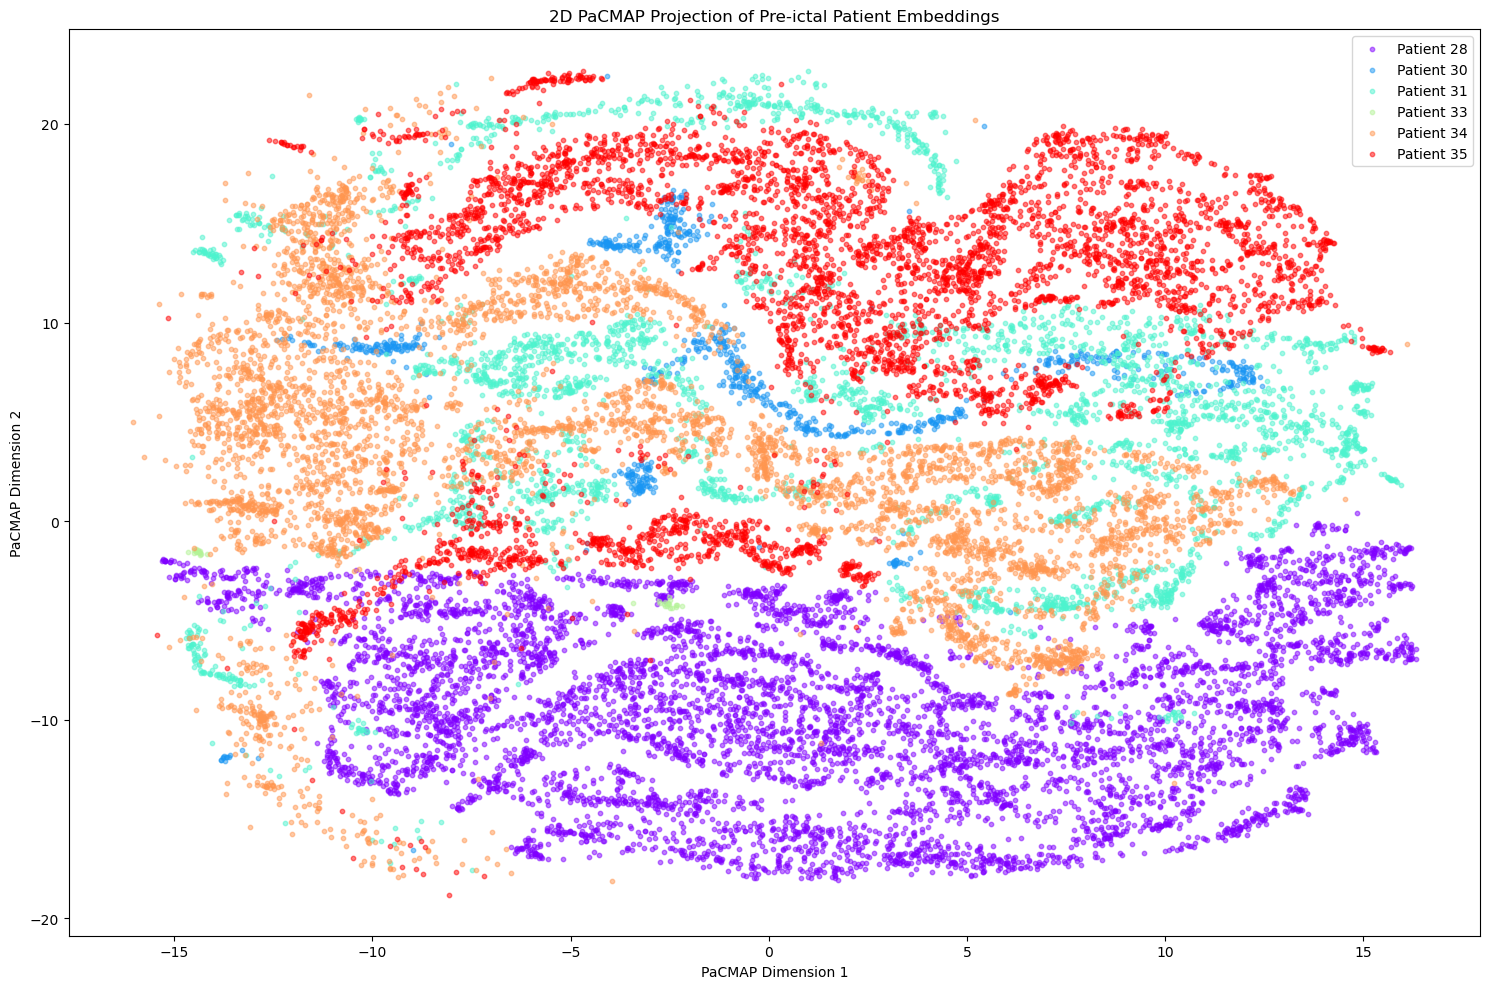

In [35]:
# Plot the results
plt.figure(figsize=(15,10))

# Expand patient IDs to match the flattened structure
expanded_patient_ids = np.repeat(combined_preictal_data['patient_id'], 32)

# Create a color map for unique patient IDs
unique_patients = sorted(set(expanded_patient_ids))
n_patients = len(unique_patients)
colors = plt.cm.rainbow(np.linspace(0, 1, n_patients))

# Plot points for each patient
for idx, patient_id in enumerate(unique_patients):
        mask = (expanded_patient_ids == patient_id)
        plt.scatter(preictal_manifold_2d[mask,0], preictal_manifold_2d[mask,1],
                c=[colors[idx]], 
                label=f'Patient {patient_id}',
                alpha=0.5, s=10)

        plt.title('2D PaCMAP Projection of Pre-ictal Patient Embeddings')
        plt.xlabel('PaCMAP Dimension 1')
        plt.ylabel('PaCMAP Dimension 2')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'figures/{animal}/multipatient/preictal_space_MN{mn_ratio}_FP{fp_ratio}_Epat28_30_31_33_34_35.svg', 
                format='svg', bbox_inches='tight')

In [18]:
# Load seizure metadata
seizure_data = pd.read_excel('metadata/ictal_event_metadata.xlsx')
print("Available columns in seizure_data:")
print(seizure_data.columns.tolist())

Available columns in seizure_data:
['Pat ID', 'Event Number (Matches EMU Final Report)', 'Date (MM:DD:YYYY)', 'Clinical Ictal Onset (HH:MM:SS) 24Hr', 'Electrographical Ictal Onset (HH:MM:SS) 24Hr', 'Electrographic Ictal Offset (HH:MM:SS) 24Hr', 'Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown)', 'Testing Performed?', 'Testing Day/Time (MM:DD:YYYY-HH:MM:SS)', 'Testing Comments', 'SOZ Leads (<name>_X-Y;<name>_Z-Q) edge case "1-1"', 'PZ Leads Within 10s of E-onset (<name>_X-Y;<name>_Z-Q) edge cases "1-1"; "None"', 'PZ leads 1s', 'PZ leads 2s', 'PZ leads 3s', 'PZ leads 4s', 'PZ leads 5s', 'PZ leads 6s', 'PZ leads 7s', 'PZ leads 8s', 'PZ leads 9s', 'PZ leads 10s', 'Comments']


Processing 43 seizure events for patient 28
Processing 3 seizure events for patient 30
Processing 9 seizure events for patient 31
Processing 2 seizure events for patient 33
Processing 25 seizure events for patient 34
Processing 16 seizure events for patient 35
Found 25461 total preictal windows


/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_2216/1849078876.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_seizures['Date (MM:DD:YYYY)'] = patient_seizures['Date (MM:DD:YYYY)'].apply(
/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_2216/1849078876.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_seizures['SeizureOnset'] = pd.to_datetime(
/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_2216/1849078876.py:32: SettingWithCopyWarning: 
A value is tr

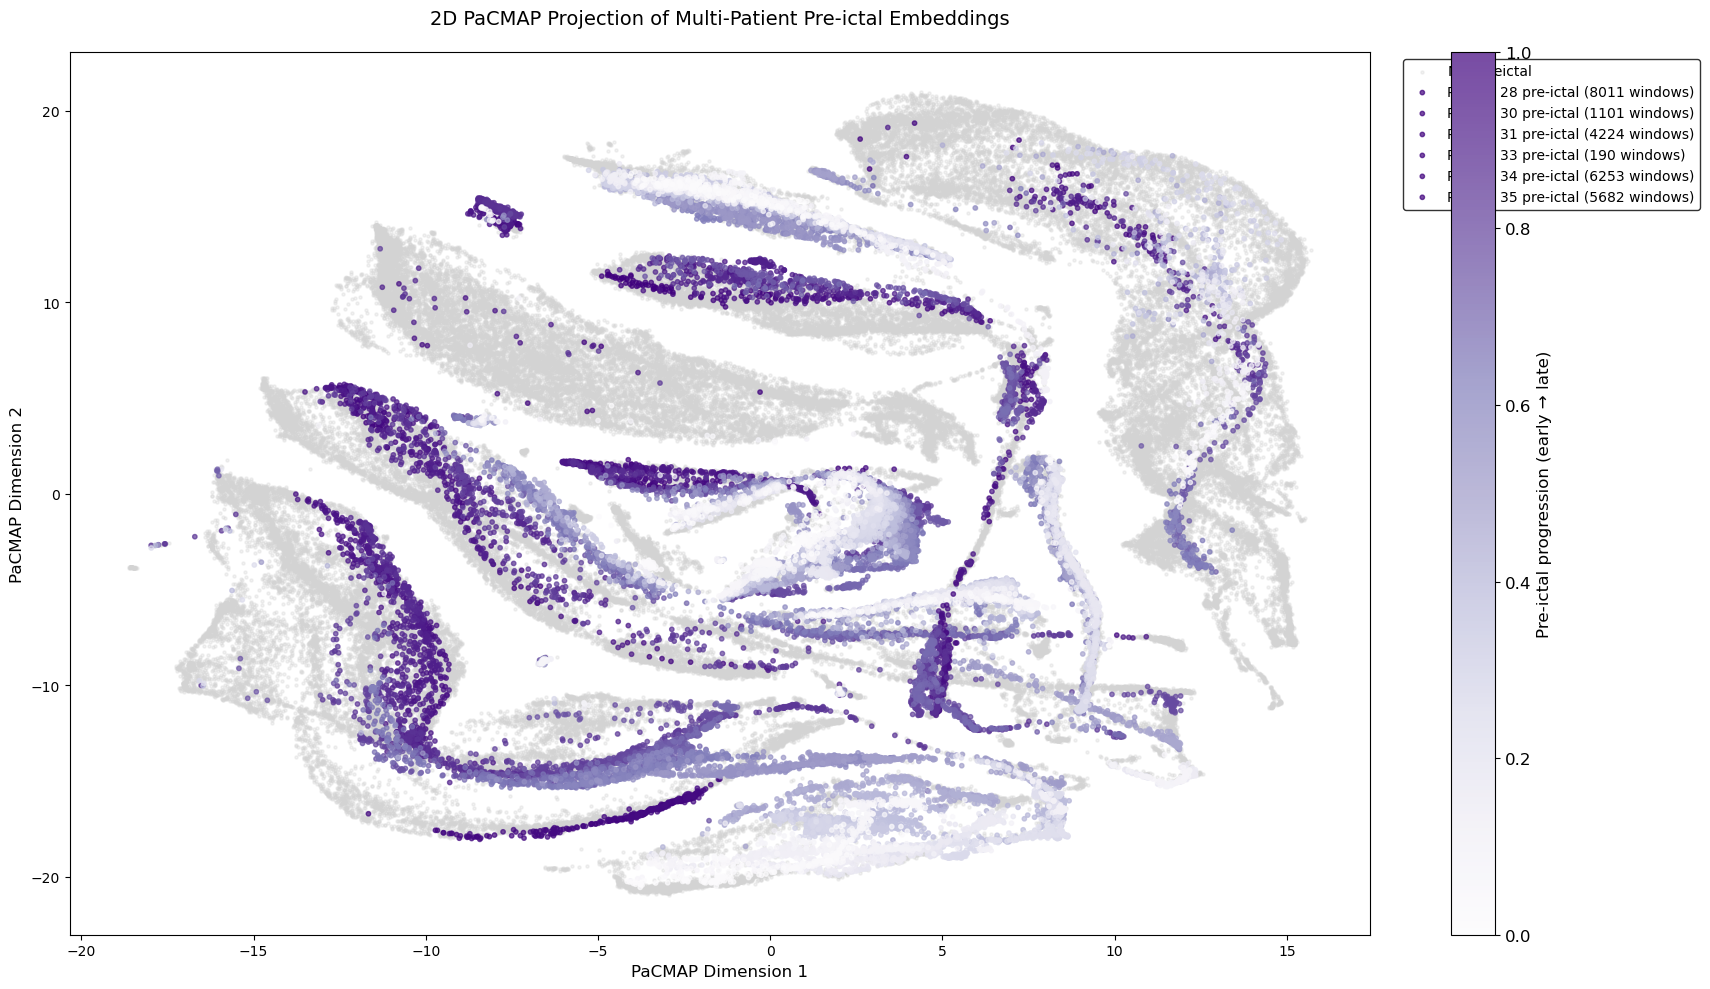

In [45]:
# Load the combined data and seizure metadata
with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)
seizure_data = pd.read_excel('metadata/ictal_event_metadata.xlsx')

# Initialize masks for all points
expanded_start_times = []
expanded_patient_ids = []

# Expand the data structure (each embedding generates 32 windows)
for i, start_time in enumerate(combined_data['start_times']):
    expanded_start_times.extend([start_time + pd.Timedelta(seconds=30*j) for j in range(32)])
    expanded_patient_ids.extend([combined_data['patient_id'][i]] * 32)

expanded_start_times = pd.to_datetime(expanded_start_times)
seizure_mask = np.zeros(len(expanded_start_times), dtype=bool)
preictal_mask = np.zeros(len(expanded_start_times), dtype=bool)
preictal_window = pd.Timedelta(minutes=240)  # 4 hours pre-ictal

# Process each patient's seizures
for patient_id in patient_list:
    # Get seizure data for this patient
    patient_seizures = seizure_data[seizure_data['Pat ID'] == f'Epat{patient_id}']
    
    if len(patient_seizures) == 0:
        print(f"No seizure events found for patient {patient_id}")
        continue
        
    print(f"Processing {len(patient_seizures)} seizure events for patient {patient_id}")
    
    # Clean and convert seizure times
    patient_seizures['Date (MM:DD:YYYY)'] = patient_seizures['Date (MM:DD:YYYY)'].apply(
        lambda x: x.split(':')[0] + '/' + x.split(':')[1] + '/' + x.split(':')[2]
    )
    
    # Create datetime objects for seizure onsets
    patient_seizures['SeizureOnset'] = pd.to_datetime(
        patient_seizures['Date (MM:DD:YYYY)'] + ' ' + 
        patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr']
    )
    
    # Mark preictal windows for this patient
    patient_mask = np.array([pid == patient_id for pid in expanded_patient_ids])
    
    for seizure_time in patient_seizures['SeizureOnset']:
        time_to_seizure = seizure_time - expanded_start_times
        preictal_mask |= (
            patient_mask & 
            (time_to_seizure <= preictal_window) & 
            (time_to_seizure > pd.Timedelta(seconds=0))
        )

print(f"Found {preictal_mask.sum()} total preictal windows")


# Plot results
plt.figure(figsize=(20,10))

# Plot non-seizure points in grey first
plt.scatter(manifold_2d[~preictal_mask,0], 
           manifold_2d[~preictal_mask,1],
           c='lightgray', alpha=0.3, s=5, label='Non-preictal')

# Get indices of preictal points
preictal_indices = np.where(preictal_mask)[0]

# Plot preictal points with color gradient by patient
unique_patients = sorted(set(expanded_patient_ids))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_patients)))

for idx, patient_id in enumerate(unique_patients):
    patient_preictal = preictal_mask & np.array([pid == patient_id for pid in expanded_patient_ids])
    patient_indices = np.where(patient_preictal)[0]
    
    if len(patient_indices) > 0:
        # Create normalized values for progression
        norm_values = np.linspace(0, 1, len(patient_indices))
        
        scatter = plt.scatter(manifold_2d[patient_indices,0], 
                            manifold_2d[patient_indices,1],
                            c=1-norm_values, 
                            cmap='Purples',  # Removed _r to fix colorbar direction
                            label=f'Patient {patient_id} pre-ictal ({len(patient_indices)} windows)',
                            alpha=0.7, s=10)
        
        if idx == 0:  # Only add colorbar for first patient
            cbar = plt.colorbar(scatter)
            cbar.ax.tick_params(labelsize=12)  # Increased font size
            cbar.set_label('Pre-ictal progression (early → late)', fontsize=12)  # Added fontsize

plt.title('2D PaCMAP Projection of Multi-Patient Pre-ictal Embeddings', fontsize=14, pad=20)
plt.xlabel('PaCMAP Dimension 1', fontsize=12)
plt.ylabel('PaCMAP Dimension 2', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Move legend outside and adjust its formatting
plt.legend(bbox_to_anchor=(1.02, 1), 
          loc='upper left', 
          fontsize=10,
          frameon=True,
          edgecolor='black')

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend

plt.savefig(f'figures/{animal}/multipatient/preictal_4hr_combined_MN{mn_ratio}_FP{fp_ratio}.svg', 
            format='svg', 
            bbox_inches='tight',
            dpi=300)